In [5]:
import os
import json
import pprint
import requests
import config 


#### download

In [6]:
''' Download path were all water level time series will be stored '''
dir_download = 'data/altimetry-water-level/dahiti'
if not os.path.isdir(dir_download):
	os.mkdir(dir_download)

API_KEY = config.dahiti_key
OUTPUT_FORMAT = 'netcdf' ## Option: ascci, json, netcdf, csv 

url = 'https://dahiti.dgfi.tum.de/api/v2/list-targets/'
args = {}
''' User configuration '''
args['api_key'] = API_KEY
''' Search options '''
# args['basin'] = 'Amazon'
# args['continent'] = 'Asia'
#args['country'] = 'de'
args['min_lon'], args['max_lon'] = 100, 106   #### 66-106
args['min_lat'], args['max_lat'] = 26, 45    #### 26-45


In [7]:
''' send request as method POST '''
response = requests.post(url, data=args)
if response.status_code == 200:
	''' convert json string in python list '''
	targets = json.loads(response.text)['data']
	print ('Dataset(s) found:',len(targets))		
	for target in targets:
		# print (target)		
		path_target_file = dir_download + '/' + str(target['dahiti_id']) + '.nc'
		if os.path.exists(path_target_file):
			print(f"File {target['dahiti_id']} already exists. Skipping download.")
			continue

		''' download water level time series '''
		url = 'https://dahiti.dgfi.tum.de/api/v2/download-water-level/'
		args = {}
		args['api_key'] = API_KEY
		args['dahiti_id'] = target['dahiti_id']
		args['format'] = OUTPUT_FORMAT		
		path_output = os.path.abspath(dir_download+'/'+str(target['dahiti_id'])+'.nc')
		print ('Downloading ... ',target['dahiti_id'],'->',target['target_name'].encode("utf8"),'('+path_output+')')		
		response_download = requests.post(url, json=args)
		if response_download.status_code == 200:
			with open(path_output, 'wb') as f:
				for chunk in response_download.iter_content(chunk_size=1024): 
					if chunk:
						f.write(chunk)
		else:
			print ('Error: `download-water-level` request failed!')
			data = json.loads(response_download.text)
			pprint.pprint(data)
			# sys.exit(0)
else:
	print ('Error: `list-targets` request failed!')
	data = json.loads(response.text)
	pprint.pprint(data)



Dataset(s) found: 17


#### Preprocessing
Write the dahiti information into geopandas dataframe.

In [8]:
import netCDF4 as nc
from glob import glob
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

dir_paths = 'data/altimetry-water-level/dahiti'
paths = glob(dir_paths+'/*.nc')
print(len(paths))


411


#### save the dahiti station information to geopandas dataframe.

In [26]:
ids, continents, contries, names, types, points = [], [], [], [], [], []
for path in paths:
    dset = nc.Dataset(path)
    ids.append(dset.dahiti_id)
    continents.append(dset.continent)
    contries.append(dset.country)
    names.append(dset.target_name.split(',')[0].strip())
    types.append(dset.target_name.split(',')[1].strip())
    points.append(Point(dset.longitude, dset.latitude))


In [27]:
d = {'id': ids, 
     'continent': continents,
      'country': contries,
      'name': names,
      'type': types,
     'geometry': points}

gdf = gpd.GeoDataFrame(d, crs="EPSG:4326")
gdf.to_file('data/altimetry-water-level/dahiti/dahiti_hma.gpkg', driver='GPKG')


Text(0.5, 1.0, 'Dahiti stations in HMA')

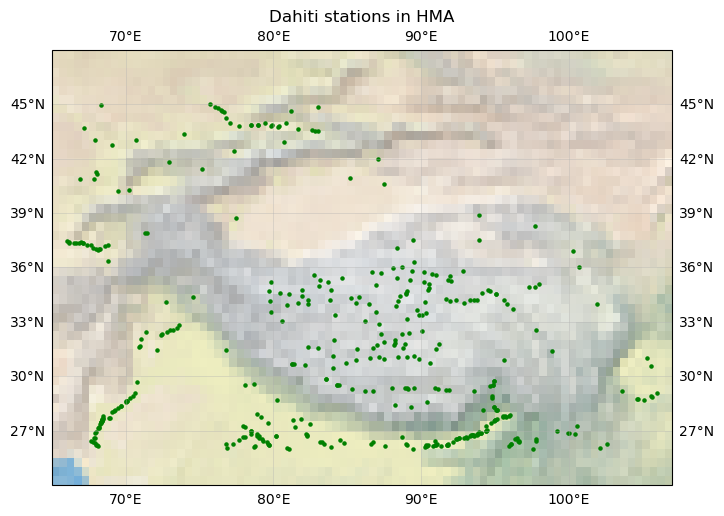

In [30]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.set_extent([65.0, 107.0, 24.0, 46.0])
ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, zorder=1)
ax.stock_img()
gdf.plot(ax = ax, facecolor='green', edgecolor='green',markersize=5)
ax.set_title('Dahiti stations in HMA')
